In [18]:
import globus_sdk
import matplotlib.pyplot as plt
import numpy as np
import csv

In [19]:
''' Access Variables '''

CLIENT_ID = '7a71f6ff-14d4-4e3a-8dbf-0e23a573f519' # this can be obtained from Apps and Services -> Projects -> Client ID
destination_endpoint_id = "9c8c88c2-ea4a-11e6-b9ba-22000b9a448b" 
source_endpoint_id_list = ["ff3045ea-a112-11ea-8f07-0a21f750d19b"]
source_dirs = "/globus/datasets/ds01/"
dest_dir = "/data/user/mmoo97/TEST_TRANSFER/"

In [ ]:
''' Code to get access token'''

client = globus_sdk.NativeAppAuthClient(CLIENT_ID)
client.oauth2_start_flow(refresh_tokens=True)

authorize_url = client.oauth2_get_authorize_url()
print('Please go to this URL and login: {0}'.format(authorize_url))

# this is to work on Python2 and Python3 -- you can just use raw_input() or
# input() for your specific version
get_input = getattr(__builtins__, 'raw_input', input)
auth_code = get_input(
    'Please enter the code you get after login here: ').strip()
token_response = client.oauth2_exchange_code_for_tokens(auth_code)

globus_auth_data = token_response.by_resource_server['auth.globus.org']
globus_transfer_data = token_response.by_resource_server['transfer.api.globus.org']
# the refresh token and access token, often abbr. as RT and AT
transfer_rt = globus_transfer_data['refresh_token']
transfer_at = globus_transfer_data['access_token']
expires_at_s = globus_transfer_data['expires_at_seconds']


In [ ]:
# Now we've got the data we need, but what do we do?
# That "GlobusAuthorizer" from before is about to come to the rescue

authorizer = globus_sdk.RefreshTokenAuthorizer(
    transfer_rt, client, access_token=transfer_at, expires_at=expires_at_s)

tc = globus_sdk.TransferClient(authorizer=authorizer)

# high level interface; provides iterators for list responses
print("My Endpoints:")
for ep in tc.endpoint_search(filter_scope="recently-used"):
    print("[{}] {}".format(ep["id"], ep["display_name"]))
    
    
for task in tc.task_list():
    print("Task({}): {} -> {}".format(
        task["task_id"], task["source_endpoint"],
        task["destination_endpoint"]))
    

In [ ]:
tc.update_task
tdata = globus_sdk.TransferData(tc, source_endpoint_id_list[0],
                                 destination_endpoint_id,
                                 label="Dataset Test",
                                sync_level=None, verify="checksum")
# tdata.add_item("/globus/datasets/ds04/", "/data/user/mmoo97/TEST_TRANSFER/",
#                 recursive=True)
# for item in tdata.items:
#     print(item)
tdata.add_item(source_dirs, dest_dir,
                recursive=True)
transfer_result = tc.submit_transfer(tdata)
print("task_id =", transfer_result["task_id"])

In [ ]:
# task = tc.get_task(transfer_result["task_id"])
task = tc.get_task("750a002a-0901-11eb-abd6-0213fe609573")
if task["status"] == "SUCCEEDED":
    print("Task Status: " + task["status"])
    print("Effective Speed: " + str(round(task["effective_bytes_per_second"]/(1024*1024), 2)) + " MB/s")
else:
    print("Task Status: " + task["status"])
    print("MB Transferred: " + str(round(task["bytes_transferred"]/1000000, 2)) + " MB")

In [20]:
# File parse
ds_sizes = {'ds01': 0.1, 'ds04':10, 'ds06':100, 'ds08': 1000, 'ds10': 1000, 'ds12':100, 
            'ds14': 5000, 'ds16': 1000} # sizes given in gigabytes

ds_names = ['ds01', 'ds04', 'ds06', 'ds08', 'ds10', 'ds12', 
            'ds14', 'ds16']

src_to_oncampx = []
src_to_oncampy = []
oncampx_to_src = []
oncampy_to_src= []

src_to_offcampx = []
src_to_offcampy = []
offcampx_to_src = []
offcampy_to_src= []

num_rows = 0
with open('oncampus_data.csv','r') as csvfile:
    plots = csv.reader(csvfile, delimiter=',')
    for row in plots:
        try:
            if (row[0][0] == "d") and (row[0][1] == 's'):
                
                if num_rows < 8: # distinguishes transfers from source to UAB.
                    src_to_oncampx.append(ds_sizes.get(row[0]))
                    src_to_oncampy.append(float(row[3]))
                    
                if num_rows >= 8: # distinguishes transfers from UAB to source.
                    oncampx_to_src.append(ds_sizes.get(row[0]))
                    oncampy_to_src.append(float(row[3]))
            
            num_rows += 1
            
        except IndexError:
            # blank text will have been caught here
            pass
    

num_rows = 0
with open('offcampus_data.csv','r') as csvfile:
    plots = csv.reader(csvfile, delimiter=',')
    for row in plots:
        try:
            if (row[0][0] == "d") and (row[0][1] == 's'):
                
                if num_rows < 8: # distinguishes transfers remote to local 
                    src_to_offcampx.append(ds_sizes.get(row[0]))
                    src_to_offcampy.append(float(row[3]))
                    
                if num_rows >= 8: # distinguishes transfers local to remote. 
                    offcampx_to_src.append(ds_sizes.get(row[0]))
                    offcampy_to_src.append(float(row[3]))
            
            num_rows += 1
            
        except IndexError:
            # blank text will have been caught here
            pass

16
16


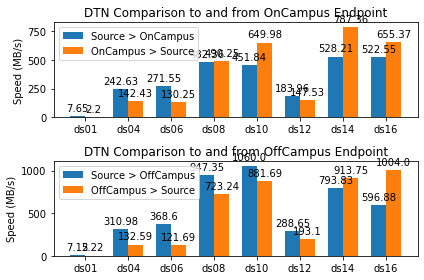

In [26]:

x = np.arange(len(ds_names))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(2, 1)
# fig.set_figheight(4)
fig.figsize()

rects1 = ax[0].bar(x - width/2, src_to_oncampy, width, label='Source > OnCampus')
rects2 = ax[0].bar(x + width/2, oncampy_to_src, width, label='OnCampus > Source')

rects3 = ax[1].bar(x - width/2, src_to_offcampy, width, label='Source > OffCampus')
rects4 = ax[1].bar(x + width/2, offcampy_to_src, width, label='OffCampus > Source')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax[0].set_ylabel('Speed (MB/s)')
ax[0].set_title('DTN Comparison to and from OnCampus Endpoint')
ax[0].set_xticks(x)
ax[0].set_xticklabels(ds_names)
ax[0].legend()

ax[1].set_ylabel('Speed (MB/s)')
ax[1].set_title('DTN Comparison to and from OffCampus Endpoint')
ax[1].set_xticks(x)
ax[1].set_xticklabels(ds_names)
ax[1].legend()

def autolabel(rects, num):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax[num].annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1, 0)
autolabel(rects2, 0)

autolabel(rects3, 1)
autolabel(rects4, 1)

fig.tight_layout()

plt.show()